# CSE 252B: Computer Vision II, Winter 2022 – Assignment 5
### Instructor: Ben Ochoa
### Due: Wednesday, March 16, 2022, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* Your code should be well written with sufficient comments to understand, but there is no need to write extra markdown to describe your solution if it is not explictly asked for.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effecient grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. If you are uncertain about using a specific package, then please ask the instructional staff whether or not it is allowable.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* Your code and results should remain inline in the pdf (Do not move your code to an appendix).
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Math): Point on Line Closest to the Origin (5 points)
  Given a line $\boldsymbol{l} = (a, b, c)^\top$, show that the point on
  $\boldsymbol{l}$ that is closest to the origin is the point $\boldsymbol{x} =
  (-ac, -bc, a^2+b^2)^\top$ (Hint: this calculation is needed in the
  two-view optimal triangulation method used below).

The required point is the point of interesection of the line $l^{'}$ through origin that is perpendicular to the given line $l$
\
\
To find this line $l^{'}$, we need to find another point on it.
\
Given that the origin $(0,0,1)$ lies on the line $l^{'}$ and its direction is given by the normal vector n = (a,b,1), any general point can be found by displacing the origin along n by a k giving a point (ak, bk, k+1)
\
Without loss of generality, let k = 1 resulting in the point (a,b,2).
\
Using the pencil of points representation, the line $l^{'}$ can be represneted as\
$l^{'} = \lambda (0,0,0) + (1-\lambda) (a,b,2) = ((1-\lambda)a, (1-\lambda b)b, (2-\lambda))$
\
As stated earlier our point of interest is the intersection of $l^{'}$ and  $ l $,
\
$l^{'T}$ $l$ = 0
\
$(1-\lambda)a^{2} + (1-\lambda)b^{2} (2-\lambda)c$ = 0
\
Solving for $\lambda$, 
\
$\lambda = \frac{a^{2}+b^{2} + 2c}{a^{2}+b^{2} + c}$
\
Substituting $\lambda$, we get the following point 
$(\frac{-ca}{a^{2}+b^{2} + c}, \frac{-cb}{a^{2}+b^{2} + c}, \frac{a^{2}+b^{2}}{a^{2}+b^{2} + c})$
\
accounting for the scale, we get the point as
\
$(-ca, -bc, a^{2}+b^{2})$

## Problem 2 (Programming): Feature Detection (20 points)
Download input data from the course website. The file IMG_5030.jpeg
contains image 1 and the file IMG_5031.jpeg contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
1350–1400 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features, where the detected features are indicated by a square window (the size of the detection window) about the features
 
A typical implementation takes around <strong>30</strong> seconds. If yours takes more than <strong>60</strong>, you may lose points.

In [1]:
%matplotlib inline
import numpy as np
from sympy import solveset, symbols, Matrix, Symbol, solve, re
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import convolve
from scipy import ndimage

def ImageGradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
    
    # Define filter kernel
    f = np.array([[-1,8,0,-8,1]])/12
    if(I.ndim == 3):
        # RGB Image
        filter_x = f[..., np.newaxis]
        filter_y = np.transpose(filter_x, (1,0,2))
    else:
        filter_x = f
        filter_y = f.T
    
    # Convolve to generate gradient images
    I_x = convolve(I, filter_x, mode = 'valid')
    I_y = convolve(I, filter_y, mode = 'valid')
    
    # Pad gradient image to restore original shape
    p = 2
    Iy = np.pad(I_y,((p,p),(0,0),(0,0)), 'constant', constant_values = 0)
    Ix = np.pad(I_x,((0,0),(p,p),(0,0)), 'constant', constant_values = 0)
    
    return Ix, Iy
  

def MinorEigenvalueImage(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    
    # Pad the Image
    p = int(w/2)
    Ix = np.pad(Ix,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)
    Iy = np.pad(Iy,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)

    #Calculate your minor eigenvalue image J0.
    for i in range(p,p+m):
        for j in range(p,p+n):
            # Extract window
            Ix_window = Ix[i-p:i+p+1,j-p:j+p+1,:]
            Iy_window = Iy[i-p:i+p+1,j-p:j+p+1,:]
            assert Ix_window.shape[0] == w, "Window mismatch in minor eigen value"
            # Compute gradient matrix entries
            Ix_2 = np.sum(np.multiply(Ix_window,Ix_window))
            Iy_2 = np.sum(np.multiply(Iy_window,Iy_window))
            Ixy = np.sum(np.multiply(Iy_window,Ix_window))
            # Compute trace and determininat
            T = Ix_2 + Iy_2
            D = Ix_2*Iy_2 - Ixy*Ixy
            k = np.maximum(T*T - 4*D,0)
            J0[i-p,j-p] =  (T - np.sqrt(k))/2
            
    return J0
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    J_max = ndimage.maximum_filter(J, size = (w_nms, w_nms), mode =  'constant', cval = 0)
    J2[J < J_max] = 0

    
    return J2
  
  
def ForstnerCornerDetector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    J0 = MinorEigenvalueImage(Ix, Iy, w)
    #Thresholding
    J1 = J0
    J1[J0<t] = 0
          
    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = NMS(J1, w_nms)
    
    #Detect corners.
    idx = np.array(np.where(J2 != 0))
    
    # Pad the Image
    p = int(w/2)
    Ix = np.pad(Ix,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)
    Iy = np.pad(Iy,((p,p),(p,p),(0,0)), 'constant', constant_values = 0)
    
    pts = []    
    for i in range(p,p+m):
        for j in range(p,p+n):
            if(J2[i-p,j-p] != 0):
                # Extract window
                Ix_window = Ix[i-p:i+p+1,j-p:j+p+1,:]
                Iy_window = Iy[i-p:i+p+1,j-p:j+p+1,:]
                assert Ix_window.shape[0] == w, "Window size mismatch in ForstnerCornerDetector"
                
                # Compute entries of gradient matrix
                Ix_2 = np.multiply(Ix_window,Ix_window)
                Iy_2 = np.multiply(Iy_window,Iy_window)
                Ixy =  np.multiply(Iy_window,Ix_window)
                                
                W_x = np.arange(j-p,j+p+1).reshape(-1,1)
                W_x = np.repeat(W_x, w, axis = 1)
                W_y = np.arange(i-p,i+p+1).reshape(1,-1)
                W_y = np.repeat(W_y, w, axis = 0)

                if(Ix_2.ndim == 3):
                    W_x = np.dstack([W_x]*3)
                    W_y = np.dstack([W_y]*3)
                                
                b0 = np.sum(np.multiply(W_y, Ixy)) + np.sum(np.multiply(W_x, Ix_2))
                b1 = np.sum(np.multiply(W_x, Ixy)) + np.sum(np.multiply(W_y, Iy_2))
                b = np.array([b0, b1])
                
                N = np.array([[np.sum(Ix_2), np.sum(Ixy)],[np.sum(Ixy), np.sum(Iy_2)]])
                pts.append(np.matmul(np.linalg.pinv(N),b)-p)
    
    
    pts = np.array(pts)
    pts = pts.T
    C = pts.shape[1]
    
    return C, pts, J0, J1, J2


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    Ix, Iy = ImageGradient(I)
    C, pts, J0, J1, J2 = ForstnerCornerDetector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

took 37.503941 secs


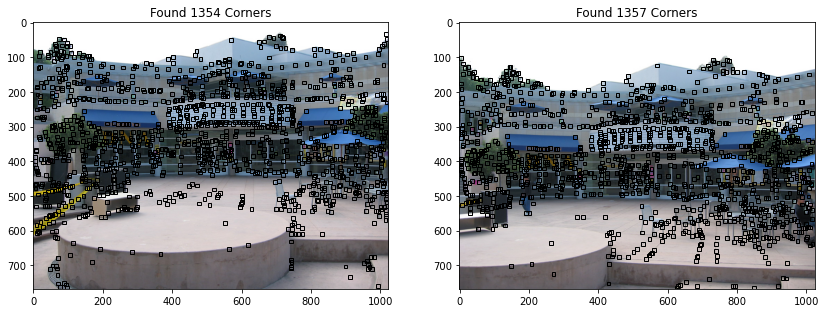

In [2]:
from PIL import Image
import time

# input images
I1 = np.array(Image.open('IMG_5030.JPG'), dtype='float')/255.
I2 = np.array(Image.open('IMG_5031.JPG'), dtype='float')/255.

# parameters to tune
w = 11
t = 0.12
w_nms = 7

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('Found %d Corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('Found %d Corners'%C2)

plt.show()

#### Final values for parameters
* w = 11
* t = 0.12
* w_nms = 7
* C1 = 1354
* C2 = 1357

## Problem 3 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that <strong>225-275</strong> putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

**Note: You must center each window at the sub-pixel corner
coordinates while computing normalized cross correlation; otherwise, you
will lose points.**

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features are indicated by a square window (the size of the matching window) about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

A typical implementation takes around <strong>40</strong> seconds. If yours takes more than <strong>80</strong> seconds, you may lose points.

In [3]:
# HELPER FUNCTIONS
def getPatch(I, xc, yc, w):
    '''
    Function performs bilinear interpolation and
    extracts patch centered at (xc,yc)
    '''
    xs = xc-int(w/2)
    ys = yc-int(w/2)
    
    xs0 = int(xs)
    ys0 = int(ys)
    xs1 = xs0 + 1
    ys1 = ys0 + 1
    
    p1 = I[xs0:xs0+w, ys0:ys0+w, :]
    p2 = I[xs1:xs1+w, ys0:ys0+w, :]
    p3 = I[xs0:xs0+w, ys1:ys1+w, :]
    p4 = I[xs1:xs1+w, ys1:ys1+w, :]
            
    I0 = p1*(xs1-xs) + p2*(xs-xs0)
    I1 = p3*(xs1-xs) + p4*(xs-xs0)
    D  = I0*(ys1-ys) + I1*(ys-ys0)
    
    return D

In [4]:
def compute_NCC(p1, p2):
    '''
    given 2 patches, function computes
    the normalized cross correlation 
    score between the 2 patches
    '''
    p1 = p1 - np.mean(p1)
    p2 = p2 - np.mean(p2)
    # Cross correlation term
    N = np.sum(np.multiply(p1,p2))
    # Auto - correlation term
    D1 = np.sum(np.multiply(p1,p1))
    D2 = np.sum(np.multiply(p2,p2))
    D = np.sqrt(D1*D2)
    return np.min(N/D)

In [5]:
def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #    
    # Do ensure that windows are centered at the sub-pixel co-ordinates 
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    C1 = pts1.shape[1]
    C2 = pts2.shape[1]
    
    P = int(w/2)
    scores = np.zeros((C1,C2))
    
    I1_pad = np.pad(I1.copy(), ((P,P),(P,P),(0,0)), 'constant', constant_values = 0)
    I2_pad = np.pad(I2.copy(), ((P,P),(P,P),(0,0)), 'constant', constant_values = 0)
        
    for i in range(C1):
        for j in range(C2):
            s = -1
            
            # proximity filter
            if np.linalg.norm(pts1[:,i]-pts2[:,j]) < p:
                # Extract patches
                xc1 = pts1[1,i] + P
                yc1 = pts1[0,i] + P
                xc2 = pts2[1,j] + P
                yc2 = pts2[0,j] + P
                
                p1 = getPatch(I1_pad, xc1, yc1, w)
                p2 = getPatch(I2_pad, xc2, yc2, w)
                
                assert p1.shape[0] == w, "Window size mismatch in NCC"
                assert p2.shape[0] == w, "Window size mismatch in NCC"
                
                s = compute_NCC(p1, p2)
                assert s>=-1 or s<=1, 'Invalid NCC value'
            
            scores[i,j] = s
            
    return scores


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
        
    inds = []
    mask = np.full(scores.shape, True, dtype=bool)
    scores_orig = scores
        
    while(np.max(scores) > t):
        idx = np.unravel_index(scores.argmax(), scores.shape)

        # Find max
        best_match = scores[idx]
        scores[idx] = -1

        # Find next best match
        next_best = np.maximum(np.max(scores_orig[idx[0],:]),np.max(scores_orig[:,idx[1]]))
        scores[idx] = best_match
        
        # Append if match good enough
        if((1-best_match) < (1-next_best)*d):
            inds.append(idx)
            
        mask[idx[0],:] = False
        mask[:,idx[1]] = False    
        
        #mask scores matrix 
        scores[np.logical_not(mask)] = -1
    inds = np.array(inds).T
    
    return inds



def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d)
    return inds

took 21.090544 secs


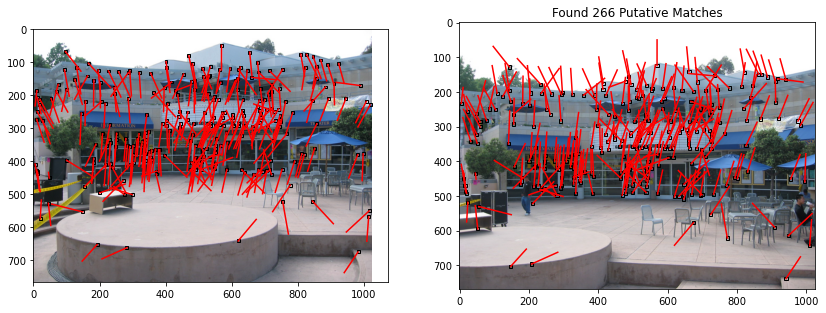

unique points in image 1: 266
unique points in image 2: 266


In [6]:
# parameters to tune
w = 9
t = 0.8
d = 0.8
p = 100

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:]]
match2 = pts2[:,inds[1,:]]

# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('Found %d Putative Matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 9
* t = 0.8
* d = 0.8
* p = 100
* num_matches = 266

## Problem 4 (Programming): Outlier Rejection (20 points)
  
  The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 7-point algorithm (as described in
lecture) to estimate the fundamental matrix, resulting in 1 or 3 solutions. Calculate 
the (squared) Sampson error as a first order approximation to the geometric error.

Hint: this problem has codimension 1

Also: fix a random seed in your MSAC. If I cannot reproduce your results, you will lose points. But don't try to find a good seed as I will run your code using different seeds. Try to get 170-220 inliers every time you run MSAC.

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 * random seed
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

In [7]:
def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

In [8]:
def computeMinimumSolverF(x1_i, x2_i):
    '''
    Compute minimum solver
    '''
    A = np.zeros((7,9))
    for i in range(7):
        A[i,:] = np.kron(x2_i[:,i], x1_i[:,i])
        
    _,_,vh = np.linalg.svd(A)
    
    F1 = vh[-1,:].reshape(3,3)
    F2 = vh[-2,:].reshape(3,3)
    
    alpha = Symbol('alpha')
    sol = solve((alpha*Matrix(F1) + Matrix(F2)).det(), alpha)
    sol = np.array(sol).astype(np.complex128)
    sol = sol[np.abs(sol.imag) < 1e-18].real
    
    F = []
    for i in range(sol.shape[0]):
        F.append(F1*sol[i] + F2)
    
    return F

In [9]:
def computeSampsonError(F, x1, x2):
    '''
    Utility function computes the sampson
    error given the F and the set of points.
    Returns the error# x1, x2 should be inhomogeneous
    '''
    assert x1.shape[0] == 2 ,'Expect inhomogeneous points for sampson error'
    f11,f12,f13,f21,f22,f23,f31,f32,f33 = F.ravel('F')
    error = []
    for i in range(x1.shape[1]):
        # Compute sampson error for each pair of points
        # J matrix
        x_ = x2[0,i]
        y_ = x2[1,i]
        x  = x1[0,i]
        y  = x1[1,i]
        J  = np.array([x_*f11+y_*f21+f31, x_*f12+y_*f22+f32, x*f11+y*f12+f13, x*f21+y*f22+f23])
    
        # Calculate Aih matrix
        x1_h = Homogenize(x1)
        x2_h = Homogenize(x2)
        epsilon = x2_h[:,i].reshape(1,-1) @ F @ x1_h[:,i].reshape(-1,1) 
                
        # Sampson Error
        e = (epsilon ** 2) / (J @ J.T)
        error.append(e)
    
    error = np.array(error)
    return error

3.841458820694124
took 15.670181 secs
120 iterations
inlier count:  176
inliers:  [  1   2   3   4   5   6   7   8   9  10  12  14  15  16  17  18  19  20
  21  23  24  26  27  28  31  32  33  34  36  37  38  40  41  42  43  44
  45  48  49  50  51  52  53  54  55  56  58  59  61  62  65  66  67  69
  70  74  75  76  77  78  79  83  84  85  90  92  93  94  95  97  99 100
 102 103 104 105 106 107 108 110 111 112 114 115 116 117 118 119 120 121
 122 123 125 126 128 131 132 134 135 142 143 144 145 146 148 149 150 151
 153 154 155 157 158 159 160 162 163 168 169 170 171 172 174 175 176 179
 180 181 183 187 188 189 190 191 192 195 197 198 199 200 202 204 207 209
 210 212 216 217 219 220 221 222 226 227 228 229 230 231 232 236 237 239
 241 243 245 246 249 250 252 253 255 257 258 259 261 265]
MSAC Cost = 467.875899945
F_MSAC =
[[-6.09018241e-09 -6.75160652e-08  8.42961723e-05]
 [ 1.10611904e-06  4.82526849e-07 -1.10371182e-02]
 [-4.72312518e-04  1.00299054e-02  9.99888670e-01]]


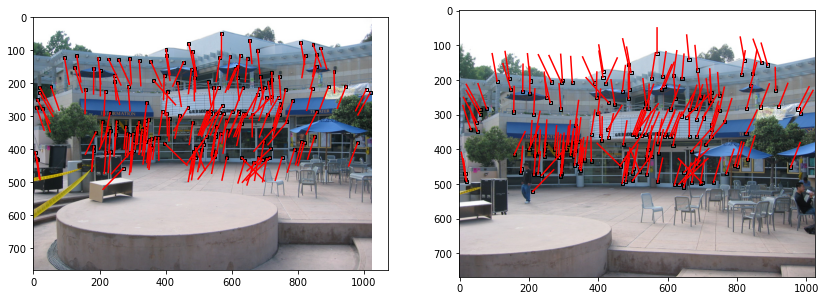

In [10]:
from scipy.stats import chi2

def DisplayResults(F, title):
    print(title+' =')
    print(F/np.linalg.norm(F)*np.sign(F[-1,-1]))

def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - fundamental matrix F
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    np.random.seed(150)
    x1 = Homogenize(pts1)
    x2 = Homogenize(pts2)
        
    consensus_min_cost = np.inf
    trials = 0
    s = 7
    max_trials = np.inf    
    while trials < max_trials:
        trials += 1
        if(consensus_min_cost <= thresh):
            break
        
        # Select random sample
        inliers = np.random.choice(range(pts1.shape[1]), 7, replace=False)
            
        # Calculate Model using Minimum Solver
        F_list = computeMinimumSolverF(x1[:,inliers], x2[:,inliers])
        
        for i in range(len(F_list)):
            # Test each solution
            F = F_list[i]
            
            # Compute Consensus cost
            consensus_cost = computeSampsonError(F, pts1, pts2)
            
            inliers_idx = np.array(np.where(consensus_cost <= tol))[0]
            consensus_cost[consensus_cost > tol]  = tol
            consensus_cost = np.sum(consensus_cost)
            
            if consensus_cost < consensus_min_cost:
                # Update Model
                inliers_opt = inliers_idx
                consensus_min_cost = consensus_cost
                consensus_min_cost_model = F

                # Update max_trials
                w = inliers_opt.shape[0]/x1.shape[1]
                max_trials = int(np.log(1-p)/np.log(1-np.power(w,s)))
                
    return consensus_min_cost, consensus_min_cost_model, inliers_opt, trials


# MSAC parameters 
thresh = 100
p = 0.99
alpha =  0.95
tol = chi2.ppf(alpha,df = 1)
print(tol)

tic=time.time()

cost_MSAC, F_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

# # Test case from TA
# xin1=np.loadtxt('hw5_pts1.txt').T
# xin2=np.loadtxt('hw5_pts2.txt').T

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost = %.9f'%cost_MSAC)
DisplayResults(F_MSAC, 'F_MSAC')

# display the figures
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)

for i in range(xin1.shape[1]):
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* random seed = 150
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 3.84
* threshold = 100
* num_inliers = 176
* num_attempts = 120
* consensus_min_cost = 467.875

## Problem 5 (Programming): Linear Estimation of the Fundamental Matrix (15 points)
  Estimate the fundamental matrix $\boldsymbol{F}_\text{DLT}$ from the
  resulting set of inlier correspondences using the direct linear
  transformation (DLT) algorithm (with data normalization).  Include
  the numerical values of the resulting $\boldsymbol{F}_\text{DLT}$, scaled
  such that $||\boldsymbol{F}_\text{DLT}||_\text{Fro} = 1$

In [11]:
def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    
    # Compute mean and variance of each dimension
    m = np.mean(pts,1).reshape(-1,1)
    v = np.var(pts,1).reshape(-1,1)
    s = np.sqrt(m.shape[0]/np.sum(v))
        
    # Create Transformation matrix
    T = np.eye(pts.shape[0]+1)
    for i in range(T.shape[0]-1):
        T[i,i] = s
        T[i,-1] = -m[i]*s
         
    # Normalize each set of points
    pts_h = Homogenize(pts)
    for i in range(pts.shape[1]):
        pts_h[:,i] = np.matmul(T, pts_h[:,i])
    return pts_h, T

In [12]:
def DLT(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    F - the DLT estimate of the fundamental matrix  
    
    if normalize:
        x1_norm, T1 = Normalize(x1)
        x2_norm, T2 = Normalize(x2)
    else:
        x1_norm = Homogenize(x1)
        x2_norm = Homogenize(x2)
        
    
    A = np.zeros((x1.shape[1],9))
    for i in range(x1.shape[1]):
        A[i,:] = np.kron(x2_norm[:,i], x1_norm[:,i])
    
    _, _, vh = np.linalg.svd(A, full_matrices=True)
    F = vh[-1,:].reshape(3,3)
    
    # Rank constraints
    U,S,Vh = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ Vh    
        
    # data denormalization
    if normalize:
        F = T2.T @ F @ T1
    
    # Calculate sampson error
    cost = computeSampsonError(F, x1, x2)
    cost = np.sum(cost)
    
    return F


# compute the linear estimate with data normalization
print ('DLT with Data Normalization')
time_start=time.time()
F_DLT = DLT(xin1, xin2, normalize=True)
time_total=time.time()-time_start

# display the resulting F_DLT, scaled with its frobenius norm
DisplayResults(F_DLT, 'F_DLT')

DLT with Data Normalization
F_DLT =
[[ 3.20265701e-09  9.95568071e-07 -3.41826734e-04]
 [ 3.23451959e-08  3.84998111e-07 -1.08543863e-02]
 [ 1.90554564e-05  9.88661756e-03  9.99892154e-01]]


## Problem 6 (Programming): Nonlinear Estimation of the Fundamental Matrix (70 points) 
  Retrieve the camera projection matrices $\boldsymbol{P} = [\boldsymbol{I} \,|\,
  \boldsymbol{0}]$ and $\boldsymbol{P}' = [\boldsymbol{M} \,|\, \boldsymbol{v}]$, where $\boldsymbol{M}$
  is full rank, from $\boldsymbol{F}_\text{DLT}$.  Use the resulting camera
  projection matrix $\boldsymbol{P}'$ associated with the second image and
  the triangulated 3D points as an initial estimate to an iterative
  estimation method, specifically the sparse Levenberg-Marquardt
  algorithm, to determine the Maximum Likelihood estimate of the
  fundamental matrix $\boldsymbol{F} = [\boldsymbol{v}]_\times \boldsymbol{M}$ that
  minimizes the reprojection error.  The initial estimate of the 3D
  points must be determined using the two-view optimal triangulation
  method described in lecture (algorithm 12.1 in the Hartley \&
  Zisserman book, but use the ray-plane intersection method for the
  final step instead of the homogeneous method).  Additionally, you
  must parameterize the camera projection matrix $\boldsymbol{P}'$ associated
  with the second image and the homogeneous 3D scene points that are
  being adjusted using the parameterization of homogeneous vectors.
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the fundamental matrix $\boldsymbol{F}_\text{LM}$, scaled
  such that $||\boldsymbol{F}_\text{LM}||_\text{Fro} = 1$.

In [14]:
def Sinc(x):
    # Returns a scalar valued sinc value
    if x == 0:
        y = 1
    else:
        y =  np.sin(x)/x
    return y

In [15]:
def initialize3DScenePoints(F, x1_inliers, x2_inliers):
    '''
    Utility function to initialize 3D
    scene points.
    '''
    x1 = Homogenize(x1_inliers)
    x2 = Homogenize(x2_inliers)
    assert x1.shape[0] == 3, 'Expect homogeonous image points'
    assert x2.shape[0] == 3, 'Expect homogeonous image points'
        
    # Get projection matrix
    P_ =getProjMatFromF(F)   
    X_scene_tri = []
    
    print('Triangulating image points ...')
    for i in tqdm(range(x1.shape[1])):
        time_start=time.time()
        T_ = np.array([[x2[2,i], 0      , -x2[0,i]],
                       [0      , x2[2,i], -x2[1,i]],
                       [0      , 0      ,  x2[2,i]]])
        T  = np.array([[x1[2,i], 0      , -x1[0,i]],
                       [0      , x1[2,i], -x1[1,i]],
                       [0      , 0      ,  x1[2,i]]])
        # Apply transformation
        #Fs = np.linalg.inv(T_.T) @ F @ np.linalg.inv(T)
        Fs = np.linalg.inv(T_).T @ F @ np.linalg.inv(T)
        
        # Compute epipole
        U,D,Vh = np.linalg.svd(Fs)
        e  = Vh[-1,:] # Fe = 0
        e_ =  U[:,-1] # F.Te'=0

        # Normalize
        e = e/np.linalg.norm(e[:2])
        e_ = e_/np.linalg.norm(e_[:2])

        # Form rotation matrices
        R  = np.array([[ e[0],e[1],0],
                      [ -e[1],e[0],0],
                      [    0,   0,1]])
        R_ = np.array([[ e_[0],e_[1],0],
                      [ -e_[1],e_[0],0],
                      [    0,   0,1]])

        f1 = e[-1]
        f2 = e_[-1]
        
        Fs = R_ @ Fs @ R.T
        # Extract terms 
        a = Fs[1,1]
        b = Fs[1,2]
        c = Fs[2,1]
        d = Fs[2,2]
        
        # solve for t
        t = symbols('t')
        exp = t*((a*t+b)**2 + f2**2*(c*t+d)**2)**2 - (a*d-b * c)*(1+(f1*t)**2)**2*(a*t+b)*(c*t+d)
        roots = list(solveset(exp,t))
            
        def cost_func_tri(tc):
            return tc**2/(1 +(f1*tc)**2) + (c*tc+d)**2/((a*tc+b)**2 + f2**2*(c*tc+d)**2)
        
        # Get candidate t
        c_min = 1/f1**2 + c*2/(a**2 + f2**2 + d**2) # at t = inf
        is_inf = True
        tc = np.inf
        for r in roots:
            r = np.complex64(r)
            r = np.real(r)
            val_c = cost_func_tri(r)
            if val_c < c_min:
                is_inf = False
                tc = r
                c_min = val_c
        
        # Get lines
        if is_inf:
            l1 = np.array([f1,0,-1])
            l2 = np.array([-f2*c,a,c])
        else:
            l1 = np.array([tc*f1,1,-tc])
            l2 = np.array([-f2*(c*tc+d), a*tc+b, c*tc+d])
        
        # Get corrected points
        x1_hat = np.array([-l1[0]*l1[2], -l1[1]*l1[2], l1[0]**2 + l1[1]**2])
        x2_hat = np.array([-l2[0]*l2[2], -l2[1]*l2[2], l2[0]**2 + l2[1]**2])
                
        # Bring back points
        x1_hat = np.linalg.inv(T) @ R.T @ x1_hat
        x2_hat = np.linalg.inv(T_) @ R_.T @ x2_hat
                
        # Epipolar line in image 2
        l_ = F @ x1_hat
        a_,b_,c_ = l_[:]
        x_,y_,w_ = x2_hat[:]
        x,y,w = x1_hat[:]
        l_perp = np.array([-b_*w_, a_*w_, b_*x_-a_*y_])
        
        # Plane 
        pi = P_.T @ l_perp
        a,b,c,d = pi[:]
        X_pi = np.array([d*x, d*y, d*w, -(a*x+b*y+c*w)])
        
        X_scene_tri.append(X_pi)
        
    print('Triangulating image points completed ...')
    X_scene_tri = np.array(X_scene_tri).T
    return X_scene_tri

In [16]:
def getProjMatFromF(F):
    '''
    Utility function to compute the 
    proj matrix from F
    '''
    U,D,Vh = np.linalg.svd(F)
    W = np.array([[0,1,0],
                  [-1,0,0],
                  [0,0,0]], dtype = np.float64)
    Z = np.array([[0,-1,0],
                  [1,0,0],
                  [0,0,1]], dtype = np.float64)
    Z = -Z.T
    
    D_ = np.array([[D[0],0,0],
                  [0, D[1], 0],
                  [0,0,(D[0]+D[1])/2]], dtype = np.float64)
    
    M = U @ Z @ D_ @ Vh
    
    e_ = np.zeros((3,1))
    S = U @ W @ U.T
    e_[0,0] = S[2,1]
    e_[1,0] = S[0,2]
    e_[2,0] = S[1,0]
    
    P_ = np.hstack((M, e_.reshape(-1,1)))
    
    return P_

In [17]:
def ParameterizeHomog(V):
    # Given a homogeneous vector V return its minimal parameterization
        
    v_hat = 2*V[1:]/Sinc(np.arccos(V[0]))    
    
    if np.linalg.norm(v_hat) > np.pi:
        v_hat = (1 - 2*np.pi/np.linalg.norm(v_hat)*np.ceil((np.linalg.norm(v_hat)-np.pi)/(2*np.pi)))*v_hat
        
    return v_hat

def parametrize(P, x):
    '''
    Homogenous parameterization of P and scene points
    '''
    assert P.shape[0] == 3 and P.shape[1] == 4, 'Expect a 3x4 proj matrix'
    assert x.shape[0] == 4, 'scene points not homogenized'
    
    # Parametrize P matrix
    P = P/np.linalg.norm(P)*np.sign(P[-1,-1])
    p = P.reshape(-1,1)
    p = ParameterizeHomog(p)
    
    
    # Parametrize each of the sampson corrected 
    # scene points
    x = x/np.linalg.norm(x, axis = 0)
    x_s_param = np.zeros((3, x.shape[1]))
    
    for i in range(x.shape[1]):
        x_s_param[:,i] = ParameterizeHomog(x[:,i]/np.linalg.norm(x[:,i])*np.sign(x[-1,i]))
    
    return p, x_s_param

In [18]:
def DeParameterizeHomog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    assert v.shape[1] == 1, 'Expect a nx1 vec in Deparam'
    a = np.array([[np.cos(np.linalg.norm(v)/2)]])
    b = v*Sinc(np.linalg.norm(v)/2)/2
    v_bar = np.vstack((a,b))
    
    return v_bar

def Deparameterize(p_param, xs_param):
    '''
    Deparametrization of homogeneous vectors
    '''
    P = DeParameterizeHomog(p_param).reshape(3,4)
    xs = np.zeros((4,xs_param.shape[1]))
    for i in range(xs_param.shape[1]):
        xs[:,i] = DeParameterizeHomog(xs_param[:,i].reshape(-1,1)).T
    return P, xs

In [19]:
def jacobianHomoParam(p):
    '''
    Helper function to compute derivative of 
    a deparam vector with a param vector.
    Param of homo representation.
    Based on (6)
    p - parametrized vector
    '''
    P_ = DeParameterizeHomog(p).reshape(1,-1)
    if (np.linalg.norm(p) == 0):
        # Norm of p is 0
        da_dv = np.zeros((1,p.shape[0]))
        db_dv = 0.5*np.eye(p.shape[0])
    else:
        # da/dv
        da_dv = -0.5*P_[0,1:]
        # ||v|| term
        v_norm = np.linalg.norm(p)
        
        # derivative of sinc
        d_sinc = np.cos(v_norm/2)/(v_norm/2) -\
        np.sin(v_norm/2)/np.square(v_norm/2)
        
        # db/dv    
        db_dv = Sinc(v_norm/2)/2*np.eye(p.shape[0]) + \
         d_sinc * np.matmul(p,p.T)/(4*v_norm)
    
    dp_bar_dp = np.vstack((da_dv, db_dv))
    assert dp_bar_dp.shape[0] == p.shape[0]+1 and dp_bar_dp.shape[1] == p.shape[0] , "Jacobian param error"
    
    return dp_bar_dp

In [20]:
def solveAugmentedNormEq(U, V, W, epsA, epsB, lam):
    '''
    Solves the augmented normal equations
    U - 11x11 matrix
    V,W- list
    epsA - 11x1 matrix
    epsB - list
    '''
    assert U.shape[0] == U.shape[1] and U.shape[0] == 11, 'U shape issue'
    
    S = U + lam*np.eye(11)
    e = epsA
    for i in range(len(V)):
        S = S - W[i] @ np.linalg.inv(V[i] + lam*np.eye(3)) @ W[i].T
        e = e - W[i] @ np.linalg.inv(V[i] + lam*np.eye(3)) @ epsB[i]
    
    assert S.shape[0] == S.shape[1] and S.shape[1] == 11 , 'S shape incorrect'
    assert e.shape[0] == 11 and e.shape[1] == 1 , 'e shape incorrect'
    
    DeltaA = np.linalg.inv(S) @ e
    assert DeltaA.shape[0] == 11 and DeltaA.shape[1] == 1, 'delta a shape issue'
    DeltaB = []
    for i in range(len(V)):
        deltaB = np.linalg.inv(V[i] + lam*np.eye(3))  @ (epsB[i] - W[i].T @ DeltaA)
        DeltaB.append(deltaB)
    return DeltaA, DeltaB

In [21]:
def computeNormalEqVec(A_, B_, B, Covarx1, Covarx2, p_param, P1, xs_param, x1, x2):
    '''
    Computes the entries of the normal vector
    '''
    # Get inhomogeneous image points
    # in img1, img2 
    
    P2, xs = Deparameterize(p_param, xs_param)        
    x1_res = Dehomogenize(x1) - Dehomogenize(P1 @ xs)
    x2_res = Dehomogenize(x2) - Dehomogenize(P2 @ xs) 
    EpsA = np.zeros((11,1))
    EpsB = []
    
    for i in range(len(A_)):
        covarx1 = np.linalg.inv(Covarx1[2*i:2*i+2,2*i:2*i+2])
        covarx2 = np.linalg.inv(Covarx2[2*i:2*i+2,2*i:2*i+2])
        EpsA = EpsA + A_[i].T @ covarx2 @ x2_res[:,i].reshape(-1,1)
        epsB = B[i].T @ covarx1 @ x1_res[:,i].reshape(-1,1) + B_[i].T @ covarx2 @ x2_res[:,i].reshape(-1,1)
        
        assert epsB.shape[0] == 3 and epsB.shape[1] == 1 ,'Shape error for epsB'
        
        EpsB.append(epsB)
        
    assert EpsA.shape[0] == 11 and EpsA.shape[1] == 1 ,'Shape error for epsA'
    return EpsA, EpsB

In [22]:
def computeNormalEqMat(A_, B_, B, Covarx1, Covarx2):
    '''
    Computes entries of the Normal equation matrix
    A_,B_,B - list 
    '''    
    U = np.zeros((11,11))
    V = []
    W = []
    for i in range(len(B)):
        covarx1 = np.linalg.inv(Covarx1[2*i:2*i+2,2*i:2*i+2])
        covarx2 = np.linalg.inv(Covarx2[2*i:2*i+2,2*i:2*i+2])
        U = U + A_[i].T @ covarx1 @ A_[i]
        v = B[i].T @ covarx1 @ B[i] + B_[i].T @ covarx2 @ B_[i]
        w = A_[i].T @ covarx2 @ B_[i]
        
        assert v.shape[0] == 3 and v.shape[1] == 3, 'Error in V shape'
        assert w.shape[0] == 11 and w.shape[1] == 3, 'Error in W shape'
        
        W.append(w)
        V.append(v)
    
    return U,V,W        

In [23]:
def computeJacobain(p2, Xs_param, P1):
    '''
    Helper function to compute jaobian
    '''
    # Get inhomogeneous image points
    # in img1, img2 
    P2, Xs = Deparameterize(p2, Xs_param)
    
    x1 = Dehomogenize(P1 @ Xs)
    x2 = Dehomogenize(P2 @ Xs)
    
    # Jacobian of x2 wrt p
    A_list = []
    # Jacobian of x2 wrt xs
    B_list = []
    # Jacobian of x1 wrt xs
    Blist  = []
    
    # derivative of deparam p wrt param h\p (6)
    a2 = jacobianHomoParam(p2)
    assert a2.shape[0] == 12 and a2.shape[1] == 11, 'A_ Jacobian error 2'
    
    for i in range(x1.shape[1]):
        #---------------------------------------------------------------------------
        # A_ = a1 @ a2
        w = P2[-1,:] @ Xs[:,i]
        # derivative of img2 wrt deparam p (8)
        a1_1 = np.hstack((Xs[:,i].reshape(1,-1), np.zeros((1,4)), -x2[0,i]*Xs[:,i].reshape(1,-1)))
        a1_2 = np.hstack((np.zeros((1,4)), Xs[:,i].reshape(1,-1), -x2[1,i]*Xs[:,i].reshape(1,-1)))
                
        a1 = np.vstack((a1_1, a1_2))
        a1 = a1/w
                
        assert a1.shape[0] == 2 and a1.shape[1] == 12 ,'A_ jacobian error'
        A_ = a1 @ a2
                
        A_list.append(A_)
        
        #---------------------------------------------------------------------------
        # B = b1 @ b2
        # Derivative of image 1 pts wrt 3D scene points
        w = P1[-1,:] @ Xs[:,i]
        b1 = np.vstack((P1[0,:] - x1[0,i]*P1[-1,:], P1[1,:] - x1[1,i]*P1[-1,:]))
        b1 = b1/w
        
        # Derivative of deparam scene points wrt param scene points
        b2 = jacobianHomoParam(Xs_param[:,i].reshape(-1,1))
        assert b1.shape[0] == 2 and b1.shape[1] == 4, 'B Jacobian error 1'
        assert b2.shape[0] == 4 and b2.shape[1] == 3, 'B Jacobian error 2'
        
        B = b1 @ b2
        Blist.append(B)
    
        #---------------------------------------------------------------------------
        # B_ = b1_ @ b2_
        # Derivative of image 2 pts wrt 3D scene points
        w = P2[-1,:] @ Xs[:,i]
        b1_ = np.vstack((P2[0,:] - x2[0,i]*P2[-1,:], P2[1,:] - x2[1,i]*P2[-1,:]))
        b1_ = b1_/w
        
        assert b1_.shape[0] == 2 and b1_.shape[1] == 4, 'B_ Jacobian error 1'
                
        B_ = b1_ @ b2
        B_list.append(B_)
        
    return A_list,B_list,Blist

In [24]:
def Normalize_withCov(pts, covarx):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    #    covarx - covariance matrix associated with x. Has size 2n x 2n, where n is number of points.
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    #    covarx - normalized covariance matrix
    
    # Compute mean and variance of each dimension
    m = np.mean(pts,1).reshape(-1,1)
    v = np.var(pts,1).reshape(-1,1)
    s = np.sqrt(m.shape[0]/np.sum(v))
        
    # Create Transform matrix
    T = np.eye(pts.shape[0]+1)
    for i in range(T.shape[0]-1):
        T[i,i] = s
        T[i,-1] = -m[i]*s
         
    # Normalize each set of points
    pts_h = Homogenize(pts)
    for i in range(pts.shape[1]):
        pts_h[:,i] = np.matmul(T, pts_h[:,i])
    
    # Covariance propagation
    covarx = (s**2)*covarx
    
    return pts_h, T, covarx

In [25]:
def computeResidualCost(P1, P2, Xs, x1, x2, Covarx1, Covarx2):
    '''
    Compute cost with covariance
    '''
    assert Xs.shape[0] == 4, 'Expect homogeneous 3d scene points'
    assert x1.shape[0] == 3, 'Expect normalized 2d image points'
       
    res1 = Dehomogenize(x1) - Dehomogenize(P1 @ Xs)
    res2 = Dehomogenize(x2) - Dehomogenize(P2 @ Xs)
    
    res1 = res1.ravel('F')
    res2 = res2.ravel('F')
    cost = res1.T @ np.linalg.inv(Covarx1) @ res1 + res2.T @ np.linalg.inv(Covarx2) @ res2
    return cost

In [26]:
from scipy.linalg import block_diag

def LM(F, x1, x2, max_iters, lam):
    # Input:
    #    F - DLT estimate of the fundamental matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    F - Final fundamental matrix obtained after convergence
        
    # Data normalization
    covarx = np.eye(2*x1.shape[1])
    x1_norm, T1, covarx1 = Normalize_withCov(x1, covarx)
    x2_norm, T2, covarx2 = Normalize_withCov(x2, covarx)
  
    # Use optimal triangulation to initialize 3D scene points
    X_scene = initialize3DScenePoints(F,x1,x2)
            
    # Data normalize 3D scene ponits
    X_scene_dehom = Dehomogenize(X_scene)
    X_scene_norm, U1 = Normalize(X_scene_dehom)
    
    # Get camera projection matrix
    P2 = getProjMatFromF(F) # Adjusted in LM
    P1 = np.hstack((np.eye(3), np.zeros((3,1))))
    
    # Data normalize Projection matrices
    Pnorm1 = T1 @ P1 @ np.linalg.inv(U1)
    Pnorm1 = Pnorm1/np.linalg.norm(Pnorm1)*np.sign(Pnorm1[-1,-1])
    Pnorm2 = T2 @ P2 @ np.linalg.inv(U1)
    Pnorm2 = Pnorm2/np.linalg.norm(Pnorm2)*np.sign(Pnorm2[-1,-1])
    
    # Initial cost
    cost_prev = computeResidualCost(Pnorm1, Pnorm2, X_scene_norm, x1_norm, x2_norm, covarx1, covarx2)
    print(cost_prev)
    n_iters = 0
    
    # Parameterize
    p2_param, Xs_param = parametrize(Pnorm2, X_scene_norm)
    
    while(n_iters < max_iters):      
        # Calculate Jacobian
        A_list,B_list,Blist = computeJacobain(p2_param, Xs_param, Pnorm1)
        
        # Compute Normal Equation Matrix
        U,V_list,W_list = computeNormalEqMat(A_list, B_list, Blist, covarx1, covarx2) # Should return U,V,W
        
        # Compute Normal Equation Vector
        epsA, epsB_list = computeNormalEqVec(A_list, B_list, Blist, covarx1, covarx2, p2_param, Pnorm1, Xs_param,\
                                             x1_norm, x2_norm) #  Should return epsilonA, epsilonB
                
        # Solve Augmented equation
        deltaA, deltaB = solveAugmentedNormEq(U, V_list, W_list, epsA, epsB_list, lam)
        
        # Get candidate
        p2_param_c = p2_param + deltaA
        Xs_param_c = []
        for i in range(Xs_param.shape[1]):
            Xs_param_c.append(Xs_param[:,i].reshape(-1,1) + deltaB[i])        
        Xs_param_c = np.concatenate(Xs_param_c, axis = 1)
        
        # Deparametrize
        P2_c , Xs_deparam_c = Deparameterize(p2_param_c, Xs_param_c)
        
        # Use adjusted P2 and P1 to calculate residual i.e. cost
        cost = computeResidualCost(Pnorm1, P2_c, Xs_deparam_c, x1_norm, x2_norm, covarx1, covarx2)
        print(cost)
        # LM Stopping conditions
        if (1 - cost/cost_prev < 1e-12):
            break
        if cost < cost_prev:
            # Valid iteration
            #print ('iter %03d Cost %.9f'%(n_iters+1, cost))
            lam = lam/10
            p2_param = p2_param_c
            Xs_param = Xs_param_c
            P2 = P2_c
            cost_prev = cost
            n_iters = n_iters + 1
        else:
            lam = lam * 10
    
    # Data denormalize
    P2 = np.linalg.inv(T2) @ P2 @ U1
    v1 = P2[0,-1]
    v2 = P2[1,-1]
    v3 = P2[2,-1]
    F = np.array([[0,-v3,v2],
                  [v3,0,-v1],
                  [-v2,v1,0]]) @ P2[:,:3]
    
    return F

# LM hyperparameters
lam = .001
max_iters = 10

# Run LM initialized by DLT estimate
print ('Sparse LM')
time_start=time.time()
F_LM = LM(F_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

# display the resulting F_LM, scaled with its frobenius norm
DisplayResults(F_LM, 'F_LM')

Sparse LM
Triangulating image points ...


100%|█████████████████████████████████████████| 220/220 [00:49<00:00,  4.47it/s]


Triangulating image points completed ...
213.18357301950692
109.97305454342468
93.98737075466137
89.03095521671372
86.9756336904891
86.06560070438664
85.64512434184482
85.44402720522504
85.34522197265
85.29569011845872
85.27049593135612
took 49.951922 secs
F_LM =
[[ 1.01969941e-09  2.48614455e-06 -7.50501122e-04]
 [-1.35749241e-06  2.53679609e-07 -1.11238757e-02]
 [ 5.07215720e-04  1.02471014e-02  9.99885211e-01]]


## Problem 7 (Programming): Point to Line Mapping (10 points)
  Qualitatively determine the accuracy of $\boldsymbol{F}_\text{LM}$ by
  mapping points in image 1 to epipolar lines in image 2.  Identify
  three distinct corners distributed in image 1 that are 
  not in the set of inlier correspondences, <i>visually</i> approximate 
  their pixel coordinates $\boldsymbol{x}_{\{1,2,3\}}$, and map them to
  epipolar lines $\boldsymbol{l'}_{\{1,2,3\}} = \boldsymbol{F}_\text{LM}
  \boldsymbol{x}_{\{1,2,3\}}$ in the second image under the fundamental
  matrix $\boldsymbol{F}_\text{LM}$.

  Include a figure containing the pair of images,
  where the three points in image 1 are indicated by a square (or
  circle) about the feature and the corresponding epipolar lines are
  drawn in image 2. Comment on the qualitative accuracy of the mapping. (Hint: each line 
  $\boldsymbol{l'}_i$ should pass through the point $\boldsymbol{x'}_i$ in image 2 that 
  corresponds to the point $\boldsymbol{x}_i$ in image 1).

/home/parth/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.


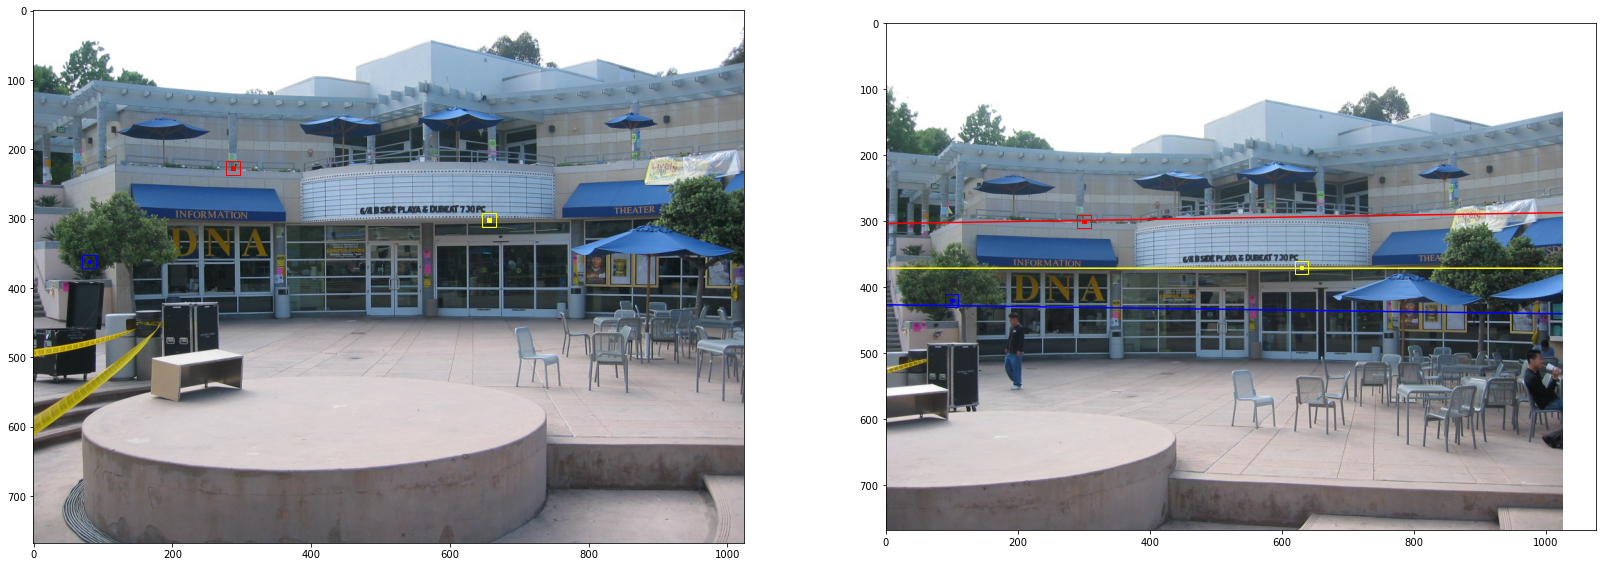

In [51]:
# Store your three points in image 1 in variable xchosen1
# Store the corresponding epipolar lines in variable epi_lines

# You can modify the code to display the figures, to highlight the corresponding point in image 2.
#    You will have to find the pixel co-ordinates of the 
#    corresponding point in image 2 manually, as we are explicitly choosing outliers(find the real matching point
#    and not the one your code outputs). The epipolar lines should
#    pass close by or through these points.
# 

np.random.seed(72)
outlier_points = set(range(pts1.shape[1]))-set(inliers)
idx = np.random.choice(len(outlier_points), 3, replace=False)
xchosen1 = pts1[:,idx]
xchosen2 = np.array([[300,300],[630,370],[100,420]]).T

# Get epipolar lines in image 2
epi_lines = F_LM @ Homogenize(xchosen1)

# display the figures
plt.figure(figsize=(28,16))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
im_height, im_width = I1.shape[:2]
x_ax = np.linspace(0, im_width, im_width*10)
colors = ['red', 'yellow', 'blue']
w1 = 20
w = 5
for i in range(xchosen1.shape[1]):
    a, b, c = epi_lines[:, i]

    xx, yy = [], []
    for xval in x_ax:
        yval = -(a/b)*xval - c/b
        if yval > 0 and yval < im_width:
            xx.append(xval)
            yy.append(yval)
    x1,y1 = xchosen1[:,i]
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=True, color=colors[i]))
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False, color=colors[i]))
    ax2.plot(xx,yy,'-r', color=colors[i])
    x2,y2 = xchosen2[:,i]
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=True, color=colors[i]))
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False, color=colors[i]))
plt.show()

"""Comment on your results here."""

The epipolar lines corresponding to the points in image 1 should pass through the corresponding points in image 2 if the Fundamental matrix computed is correct.
As indicated in the figure we can observe the same in the figure indicating that the estimate of F is a good one which satisfies the epipolar constraint.